In [1]:
# Imports

import numpy as np
import pandas as pd
import os, os.path
from itertools import *
%matplotlib inline
import matplotlib.pyplot as plt
import math
import random
import scipy.stats
import sys

# Warnings

import warnings
warnings.filterwarnings('ignore')

# Idempotent data retrieval script

chromosomes = [1, 2, 6, 7, 11]
def chromosome_files(n):
    base = 'intersected_final_chr'
    spec = '_cutoff_20_'
    suffixes = ['train.bed', 'sample_partial.bed', 'sample_full.bed']
    return [base + str(n) + spec + suffix for suffix in suffixes]
all_files = set(chain.from_iterable(chromosome_files(n) for n in chromosomes))

if 'methylation_imputation' not in [x for x in os.listdir('.') if os.path.isdir(x)]:
    raise Exception('Missing assignment repository in cwd')

if not os.path.exists('data'):
    os.mkdir('data')

def all_files_present(): return all_files.issubset(set(os.listdir('data')))
if not all_files_present():
    ! gunzip -k methylation_imputation/data/*.bed.gz
    ! mv methylation_imputation/data/*.bed data/
    if not all_files_present():
        raise Exception('Error unpacking data')

def read_tsv(name): return pd.read_csv(name, sep='\t', header=None)
train_chr1 = read_tsv('data/' + chromosome_files(1)[0])
test_chr1_partial = read_tsv('data/' + chromosome_files(1)[1])
test_chr1_full = read_tsv('data/' + chromosome_files(1)[2])

unknown_chr1_ix = np.where((test_chr1_partial[5] == 0) & ~np.isnan(test_chr1_full[4]))[0]
known_chr1_ix = np.where((test_chr1_partial[5] == 1) & ~np.isnan(test_chr1_partial[4]))[0]

test_ix = unknown_chr1_ix
train_ix = known_chr1_ix

train_df = train_chr1
train_tissues = ['b' + str(x) for x in range(train_chr1.shape[1] - 4)]
train_df.columns = ['chromosome', 'start', 'end', 'strand'] + train_tissues

test_df = test_chr1_full
test_df.columns = ['chromosome', 'start', 'end', 'strand', 'filled', 'assayed']
test_df['missing'] = test_chr1_partial[4]

train_df['strand'] = train_df['strand'] == '+'
test_df['strand'] = test_df['strand'] == '+'

In [2]:
train_df.loc[range(267, 273)]

,chromosome,start,end,strand,b0,b1,b2,b3,b4,b5,...,b24,b25,b26,b27,b28,b29,b30,b31,b32,b33
267,chr1,121511,121513,True,0.714286,0.739130,0.800000,0.782609,0.794872,0.750000,...,0.860465,0.789474,NaN,0.727273,0.896552,0.810811,0.809524,0.842105,0.880000,0
268,chr1,121516,121518,True,0.857143,0.800000,0.833333,0.913043,0.909091,0.806452,...,0.931818,0.888889,NaN,0.840000,0.862069,0.756757,0.916667,0.833333,0.916667,0
269,chr1,122736,122738,False,0.545455,0.384615,0.472727,NaN,0.436364,0.580000,...,0.487179,NaN,NaN,NaN,0.413043,0.462963,0.533333,0.659574,0.682927,0
270,chr1,122869,122871,False,0.837838,0.814815,0.725000,0.807692,0.710526,0.565217,...,0.629630,NaN,NaN,NaN,0.755556,0.590909,0.681818,0.657143,NaN,0
271,chr1,122884,122886,False,0.842105,0.821429,0.720930,0.800000,0.795455,0.478261,...,0.617021,NaN,NaN,NaN,0.682927,0.562500,0.739130,0.666667,0.756098,0
272,chr1,127749,127751,True,0.633333,0.473684,0.703704,0.611111,0.827586,0.666667,...,0.782609,0.800000,NaN,0.812500,0.500000,0.812500,0.840909,0.687500,0.807692,0


In [3]:
assert len(train_df) == len(test_df)
def count_unique(col):
    return {x:sum(col == x) for x in set(col)}

print('Chromosome 1')
print('Total samples', len(train_df))
print('Site lengths', count_unique(train_df['end'] - train_chr1['start']))
print('Strand types', count_unique(train_df['strand']))
print('Known (test) sample site counts', len(known_chr1_ix))
print('Unknown (test) sample site counts', len(unknown_chr1_ix))
print('NaN ratio in all train samples',
      sum(sum(np.isnan(train_df[train_tissues].values))) / (len(train_df) * len(train_tissues)))
print('NaN ratio in test', sum(np.isnan(test_df['missing'])) / len(test_df))
assert sum(test_df['strand'] != train_df['strand']) == 0

Chromosome 1
Total samples 379551
Site lengths {2: 379551}
Strand types {False: 1464, True: 378087}
Known (test) sample site counts 7523
Unknown (test) sample site counts 368411
NaN ratio in all train samples 0.0849950103582
NaN ratio in test 0.980179211753


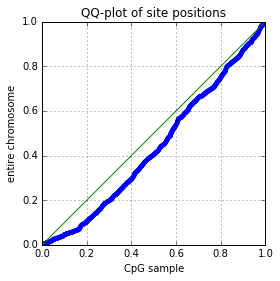

avg length between known sites 50.2903483116
sd of number of bp between sites 86.9614546017


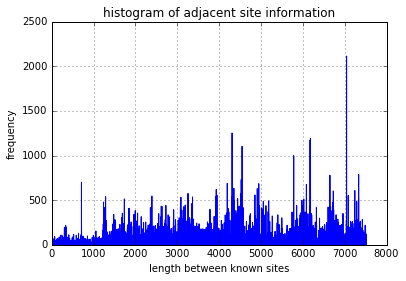

In [4]:
# Make sure our samples are pretty uniform from the genomic range
def ticks(n): return np.arange(0.0, n) / n
plt.plot(ticks(len(known_chr1_ix)), known_chr1_ix / len(train_df), '.')
plt.plot([0, 1])
plt.axes().set_aspect('equal')
plt.xlabel('CpG sample')
plt.ylabel('entire chromosome')
plt.title('QQ-plot of site positions')
plt.grid(True)
plt.show()

diffs = np.diff(known_chr1_ix)
print('avg length between known sites', np.mean(diffs))
print('sd of number of bp between sites', np.std(diffs))
plt.plot(np.diff(known_chr1_ix))
plt.xlabel('length between known sites')
plt.ylabel('frequency')
plt.title('histogram of adjacent site information')
plt.grid(True)
plt.show()

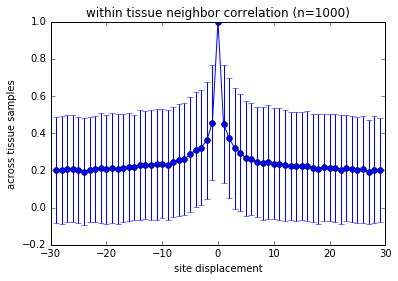

In [5]:
# Observe nearby site correlations
def drop_nan_corr(x, y):
    ix = np.where(~np.isnan(y) & ~np.isnan(x))
    return scipy.stats.pearsonr(x[ix], y[ix])[0]
# Choose a random site, check neighbors within vicinity of 'reach'
reach = list(range(30))
reach = [-x for x in reversed(reach)] + reach[1:]
def sample_corr(reach):
    site = random.randint(max(reach), len(train_chr1) - max(reach) - 1)
    y = np.array(train_df.iloc[site][train_tissues[:-1]]
                 .values).astype(np.float64)
    nbrs = [site + i for i in reach]
    xs = np.array(train_df.iloc[nbrs][train_tissues[:-1]]
                  .values).astype(np.float64)
    return np.array([drop_nan_corr(x, y) for x in xs])

sample = 1000
test = np.array([sample_corr(reach) for i in range(sample)])
plt.errorbar(reach, np.mean(test, axis=0), fmt='-o', yerr=np.std(test, axis=0))
plt.title('within tissue neighbor correlation (n={})'.format(sample))
plt.ylabel('across tissue samples')
plt.xlabel('site displacement')
plt.show()

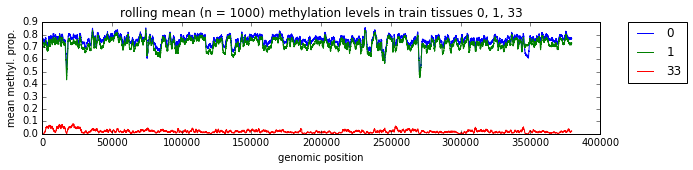

orig : rolling mean stddevs [4.8264430391409112, 4.6245001454552384, 11.339790875795508]


In [6]:
# Perhaps there are obvious sequence trends?
def local_impute(data):
    #http://stackoverflow.com/questions/9537543/replace-nans-in-numpy-array-with-closest-non-nan-value
    mask = np.isnan(data)
    data[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data[~mask])
    return data

plt.figure(figsize=(10, 2))
ratios = []
plt.title('rolling mean (n = 1000) methylation levels in train tissues 0, 1, 33')
plt.xlabel('genomic position')
plt.ylabel('mean methyl. prop.')

x = local_impute(np.copy(train_df['b0']))
rolled = pd.Series(x).rolling(window=1000, win_type='boxcar').mean()
ratios.append(np.std(x) / np.std(rolled))
l0, = plt.plot(rolled, label='0')

x = local_impute(np.copy(train_df['b1']))
rolled = pd.Series(x).rolling(window=1000, win_type='boxcar').mean()
ratios.append(np.std(x) / np.std(rolled))
l1, = plt.plot(rolled, label='1')

x = local_impute(np.copy(train_df['b33']))
rolled = pd.Series(x).rolling(window=1000, win_type='boxcar').mean()
ratios.append(np.std(x) / np.std(rolled))
l33, = plt.plot(rolled, label='33')

plt.legend(handles=[l0, l1, l33])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
print('orig : rolling mean stddevs', ratios)

In [7]:
# Sparsity
print('Training tissue sparsities', [sum(train_df[i] <= 0.01) / len(train_df) for i in train_tissues])
print('Sample sparsity', sum(test_df['filled'][train_ix] == 0.01) / len(train_ix))

Training tissue sparsities [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.97994999354500445]
Sample sparsity 0.0


In [23]:
# Define some evaluation functions

def denanify(a, b):
    mask = ~np.isnan(a) & ~np.isnan(b)
    assert sum(mask) > 0
    return a[mask], b[mask]

def pandas_rmse(a, b):
    # http://stackoverflow.com/questions/27783494/root-mean-square-error-of-two-pandas-series
    return math.sqrt(a.sub(b).pow(2).mean())

def correct_half(a, b):
    methylated_guess = a >= 0.5
    methylated_exact = b >= 0.5
    return sum(methylated_guess == methylated_exact) / len(methylated_guess)

# Function f should return its estimate for the value in 'test_tissue'
# at each test_ix location. It gets its own copy of test_tissue, but
# train_cols is shared.
def eval_fold(f, train_cols, test_tissue, train_tissue_names):
    nanned = test_tissue.copy()
    nanned[test_ix] = np.nan
    guess = f(train_cols, nanned, train_tissue_names)
    assert sum(np.isnan(guess)) == 0
    # test_ix doesn't have nans in the test_df['filled'] col, but
    # within train_df there might be nans here.
    exact = test_tissue[test_ix]
    if not isinstance(guess, pd.Series):
        guess = pd.Series(guess, index=exact.index)
    assert len(guess) == len(exact)
    guess, exact = denanify(guess, exact)
    return np.array([pandas_rmse(guess, exact), correct_half(guess, exact)])

from joblib import Parallel, delayed
nproc = 4

# Excludes the sparse chromosome from testing.
def cv_folds(f, df=train_df, threading='multiprocessing'):
    test_tissues = train_tissues[:-1]
    rmse_acc = np.zeros(2)
    ctr = 0
    arguments = []
    for t in test_tissues:
        train_cols = train_tissues[:]
        train_cols.remove(t)
        train_cols += ['strand'] # TODO: encode data
        arguments.append((f, df[train_cols], df[t], train_cols))
    folds = [eval_fold(*i) for i in arguments] if not threading else \
            Parallel(n_jobs=nproc, backend=threading) \
                (delayed(eval_fold)(*i) for i in arguments)
    return sum(folds) / len(folds)

def perfstr(rmse_acc):
    return 'rmse {} methylated acc {}'.format(*rmse_acc)

In [11]:
# No trends.
# Let's try imputing from but clearly we can impute from local neighbor data.
# Try using no information for our test chromosome as a baseline.

# Two simple approaches, with no information from other samples

def interpolation(cols, partial, train_tissue_names):
    return local_impute(partial).iloc[test_ix]
print('interpolation', perfstr(cv_folds(interpolation)))

def mean_impute(data):
    mask = np.isnan(data)
    data[mask] = float(data.mean()) # just = m messes with serialization
    return data

def same_sample_mean(cols, partial, train_tissue_names):
    return mean_impute(partial).iloc[test_ix]
print('same tissue mean', perfstr(cv_folds(same_sample_mean)))

interpolation rmse 0.23598852306080018 methylated acc 0.8086466369349822
same tissue mean rmse 0.19061351784292757 methylated acc 0.8847172102962194


In [12]:
# As a dual approach, we can try using only information from the remaining tissues
# For example, we might try to take a mean of methylation values along the same site
def diff_sample_mean(cols, partial, train_tissue_names):
    return cols[train_tissue_names].iloc[test_ix].mean(axis=1)
print('diff tissue mean', perfstr(cv_folds(diff_sample_mean)))

diff tissue mean rmse 0.1428387141683678 methylated acc 0.9109640807386484


In [13]:
# Do local imputation on our training data.
train_df_imp = train_df
for i in train_tissues:
    train_df_imp[i] = mean_impute(train_df[i].copy())
sum(sum(np.isnan(train_df_imp[train_tissues].values)))

0

In [28]:
# Use the well-formedness of the other-tissue data to train a basic lm
def sklearn_model(lm, cols, partial, train_tissue_names):
    lm.fit(cols.iloc[train_ix], partial.iloc[train_ix])
    return lm.predict(cols.iloc[test_ix])

from functools import partial
from sklearn import linear_model
from sklearn import ensemble
def log_range(lo, hi): return [10 ** i for i in range(lo, hi)]
regs = log_range(-4, 4)

models = [
    ('OLS', linear_model.LinearRegression()),
    ('Ridge', linear_model.RidgeCV(alphas=regs)),
    ('Lasso', linear_model.LassoCV(alphas=regs)),
    ('RFR', ensemble.RandomForestRegressor(n_estimators=50))
]

for name, model in models:
    print(name, perfstr(cv_folds(partial(sklearn_model, model), df=train_df_imp)))

OLS rmse 0.09235757785888475 methylated acc 0.9496019884906209
Ridge rmse 0.09231778317942294 methylated acc 0.9495822476922391
Lasso rmse 0.09225219661446737 methylated acc 0.949593516397982
RFR rmse 0.09296418390803307 methylated acc 0.9483394821807626


In [ ]:
def plotresid(model, name):
    res = model.predict(train_df_interp.iloc[test_ix][df_feat].values)
    res -= test_df.iloc[test_ix]['filled']
    plt.hist(res, bins=50)
    plt.xlabel('residual')
    plt.ylabel('frequency')
    plt.title('residuals for site-based ' + name)
    plt.grid(True)
    plt.show()

In [ ]:
# Annoying R interfacing for beta regression

# https://sites.google.com/site/aslugsguidetopython/data-analysis/pandas/calling-r-from-python

# TODO rm extra imports
#from numpy import *
#import scipy as sp
#from pandas import *
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
import pandas.rpy.common as com
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

train_rdf = com.convert_to_r_dataframe(train_df_imp)
test_rdf = com.convert_to_r_dataframe(test_df)

In [ ]:
ro.globalenv['train_rdf'] = train_rdf
ro.globalenv['test_rdf'] = test_rdf
ro.globalenv['train_ix'] = train_ix + 1
ro.globalenv['test_ix'] = test_ix + 1

In [ ]:
rcmd = 'lm(test_rdf$filled ~ ' + ' + '.join(train_tissues) + ', data=train_rdf, subset=train_ix)'
ro.r('fit <- ' + rcmd)
print(ro.r('summary(fit)'))

In [ ]:
rpred = 'predict(fit, train_rdf[test_ix,])'
rexact = 'test_rdf[test_ix,]$filled'
print('lm rmse', ro.r('sqrt(mean((' + rpred + '-' + rexact + ') ^ 2))'))
ro.r('linear_coef <- coef(fit)')
ro.r('linear_coef[length(linear_coef)] = 0')
ro.r('linear_coef')

In [ ]:
importr('betareg')
# chr33 is mostly sparse, not converging with it
rcmd = 'betareg(test_rdf$filled ~ ' + ' + '.join(train_tissues[:-1]) + \
    ', data=train_rdf, subset=train_ix' + \
    ', start=list(mean=head(linear_coef, -1), precision=1))'
ro.r('fit <- ' + rcmd)
print(ro.r('summary(fit)'))
rpred = 'predict(fit, train_rdf[test_ix,])'
rexact = 'test_rdf[test_ix,]$filled'
print(ro.r('sqrt(mean((' + rpred + '-' + rexact + ') ^ 2))'))